<a href="https://colab.research.google.com/github/edsoncezar16/Reinforcement_Learning/blob/main/Q_learning_studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning Agent with environment-adaptive decay rates

## Abstract 

We develop a Q-learning Agent class with exponential decay of exploration probability and learning rate. We provide heuristics for the characteristic decaying time and investigate the effect of non-zero asymptotic values. We test the agent on several openAI gym environments and verify that the provided heuristic performs quite well, that asymptotic exploration probabilities degrade performance, and asymptotic learning rates degrade sample efficiency.


## FrozenLake

We discuss here the information available in the [description of the environment](https://gym.openai.com/envs/FrozenLake-v0/) that are relevant for our task.

Regarding the environment dynamics, we have the following:

>The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Therefore, this is a **stochastic** environment, so that the return of a single episode is not an appropriate performance metric. Instead, we will use an *exponentially weighted average* return.

Regargind the rewards:

>The surface is described using a grid like the following:

>SFFF       (S: starting point, safe)

>FHFH       (F: frozen surface, safe)

>FFFH       (H: hole, fall to your doom)

>HFFG       (G: goal, where the frisbee is located)

>The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Since there is no penalty for the agent when taking too long to reach the goal, we should set up the parameter $\gamma$ to be less than unity, as this will encourage the agent to finish the task as quickly as possible.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import joblib

## Creating the environment

In [2]:
FrozenLake8x8=gym.make('FrozenLake8x8-v0')

# visualize the environment
FrozenLake8x8.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### Visualizing sample transitions 

In [3]:
for _ in range(5):

    state=FrozenLake8x8.observation_space.sample()
    print('Sample state:'+str(state))
    for action, transitions in FrozenLake8x8.P[state].items():
         print("")
         print("Action:"+str(action))
         print("Possible transitions:")
         for transition in transitions:
             print(transition)
    print("#############################################\n")

Sample state:51

Action:0
Possible transitions:
(0.3333333333333333, 43, 0.0, False)
(0.3333333333333333, 50, 0.0, False)
(0.3333333333333333, 59, 0.0, True)

Action:1
Possible transitions:
(0.3333333333333333, 50, 0.0, False)
(0.3333333333333333, 59, 0.0, True)
(0.3333333333333333, 52, 0.0, True)

Action:2
Possible transitions:
(0.3333333333333333, 59, 0.0, True)
(0.3333333333333333, 52, 0.0, True)
(0.3333333333333333, 43, 0.0, False)

Action:3
Possible transitions:
(0.3333333333333333, 52, 0.0, True)
(0.3333333333333333, 43, 0.0, False)
(0.3333333333333333, 50, 0.0, False)
#############################################

Sample state:27

Action:0
Possible transitions:
(0.3333333333333333, 19, 0.0, True)
(0.3333333333333333, 26, 0.0, False)
(0.3333333333333333, 35, 0.0, True)

Action:1
Possible transitions:
(0.3333333333333333, 26, 0.0, False)
(0.3333333333333333, 35, 0.0, True)
(0.3333333333333333, 28, 0.0, False)

Action:2
Possible transitions:
(0.3333333333333333, 35, 0.0, True)
(0.3

From the [Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py), we know the action meanings are:

* 0: left
* 1: down
* 2: right
* 3: up

Therefore, from these sample transitions, we might infer that the environment dynamics is as follows: after selecting an action a, there is 1/3 probability the agent will manage to do it, 1/3 it will end up executing action a-1 mod 4, and 1/3 it will end up doing action a+1 mod 4. These dynamics simulate slipping.

## Implementing a Q-learning Agent class

We will use the following $\epsilon$ parameter schedule:
$$\epsilon(n)=\epsilon_\infty+(1-\epsilon_\infty)\exp\left(-\frac{n}{n_d}\right),$$

or
$$\epsilon(n+1)=\exp\left(-\frac{1}{n_d}\right)\epsilon(n)+\left(1-\exp\left(-\frac{1}{n_d}\right)\right) \epsilon_\infty, \epsilon(0)=1,$$
where $n$ is the number of episodes the agent has played, and $n_d$ is a decay constant. The goal here is to investigate to what extent the terminal exploration probability $\epsilon_\infty$ impacts the asymptotic performance.

To set a reasonable value for $n_d$, we will follow this heuristic: the more complex the environment is, the more episodes the agent needs to learn something significant about each state-action value. The environment parameters that seem more relevant to characterize such environment complexity are the number of state-action pairs and possible transitions. Therefore, we estimate that the decay constant should be close to:
$$n_d=env.nS*env.nA*\bar{t}$$,
where $\bar{t}$ is the average number of possible transitions after taking some action.

We also note that similar reasoning applies to the learning rate: at the beginning, we want the agent to react strongly to recent rewards since it has no clue about the action values. However, we want the learning process to become smoother as the agent becomes more experienced so that the Q values estimates become stable. However, in general, we want a non-zero terminal value $\alpha_\infty$ because the agent should always be learning at a sensible rate in case the environment dynamics change.  

Therefore, we will also implement a decaying learning rate with a simillar schedule:

$$\alpha(n)=\alpha_\infty+(1-\alpha_\infty)\exp\left(-\frac{n}{n_d}\right),$$

or

$$\alpha(n+1)=\exp\left(-\frac{1}{n_d}\right)\alpha(n)+\left(1-\exp\left(-\frac{1}{n_d}\right)\right) \alpha_\infty, \alpha(0)=1,$$

using the same decay constant of the $\epsilon$ parameter for simplicity.

The terminal values for these parameters are relevant in **non-stationary** environments because we always want exploration and learning at sensible rates to account for the changes in the environmental dynamics. 

However, in this case, we have a **stationary** environment, so that we set these terminal values to 0.0 as default and investigate the effects of non-zero values later on.

In [44]:
class Q_learning_Agent():
    """
    A Q-learning agent that adapts to environments with discrete state and 
    action spaces and uses environment adaptive exponential decay for the
    exploration probability and the learning rate.

    Args:
        name (str): the agent's name.
        gamma (float): the discount factor (defaults to 1.0).
        alpha_inf (float): the asymptotic learning rate (defaults to 0.01).
        epsilon_inf (float): the asymptotic exploration probability (defaults to
            0.01).
    
    Attributes:
        name (str): the agent's name.
        gamma (float): the discount factor. 
        alpha_inf (float): the asymptotic learning rate.
        epsilon_inf (float): the asymptotic exploration probability.
        Q (numpy.ndarray): the agent's Q table.
        history (list): contains the returns from every episode the agent has 
            played.
        decay_weight (float): defines the learning rate and exploration
            probability for the next episode.
        alpha (float): the current learning rate.
        epsilon (float): the current exploration probability.
        state (int): the agent's current state.
        previous_state (int): the agent's previous state
        action (int): the last chosen action.
  
    Methods: 
        compute_decay_weight
        reset_to_env
        play
    """

    def __init__(self, name, gamma=1.00, alpha_inf=0.01, epsilon_inf=0.01): 
        self.name=name 
        self.gamma=gamma
        self.alpha_inf=alpha_inf
        self.epsilon_inf=epsilon_inf
        self.Q=None 
        self.history=None
        self.decay_weight=None 
        self.alpha=None
        self.epsilon=None
        self.state=None
        self.previous_state=None
        self.action=None
    
    def compute_decay_weight(self, environment):
        """
        Sets the agent's decay weight based on the environment's complexity.

        Args:
            environment (openAI gym environment): the environment we want the 
                agent to learn. Must have discrete space and action spaces.
        
        Returns:
            None 
        """

        #average transitions number computation
        t_avg=0
        for state in range(environment.nS):
            for action in range(environment.nA):
                t_avg+=len(environment.P[state][action])
        t_avg=int(round(t_avg/(environment.nS*environment.nA)))
        self.decay_weight=1.0-np.exp(-1/(t_avg*environment.nA*environment.nS))
    
    def reset_to_env(self,environment):
        """ 
        Resets the agent's attributes to begin learning on a new environment.

        Args:
            environment (openAI gym environment): the environment we want the 
                agent to learn. Must have discrete space and action spaces.
      
        Returns:
            None
        """

        self.Q=np.zeros((environment.nS, environment.nA))
        self.history=[]
        self.compute_decay_weight(environment)
        self.alpha=1.0
        self.epsilon=1.0

    def play(self, environment, episodes=None, view=False):
        """
        Agent plays some episodes on the environment, learns and stores the 
        episodes returns on it's 'history'.

        Args:
            environment (openAI gym environment): the environment we want the 
                agent to learn. Must have discrete space and action spaces.
            episodes (int/None): the number of episodes to play. If None, it is
                set to 10 times the characteristic decay time of the agent's
                parameters (defaults to None).
            view (bool): whether or not to render the interaction (defaults to
                False).

        Returns:
            None
        """

        if episodes is None:
            episodes=10*int(round(1.0/np.log(1.0/(1.0-self.decay_weight))))

        for _ in range(episodes):
            self.previous_state=None
            self.state = environment.reset() # initial state for episode
            time_step=0
            episode_return=0.0

            while True:
                if view:
                    environment.render()

                # action selection
                if np.random.rand()<self.epsilon: # explore
                    self.action=np.random.choice(environment.nA)
                else: # exploit
                    self.action=np.random.choice(np.flatnonzero(self.Q[self.state]==np.amax(self.Q[self.state]))) # argmax with random 
                    # breaking ties

                # Observation 
                self.previous_state=self.state
                self.state, reward, done, info = environment.step(self.action)
                episode_return+=reward*self.gamma**time_step

                # Q learning
                self.Q[self.previous_state][self.action]+=self.alpha*\
                (reward+self.gamma*np.amax(self.Q[self.state])-self.Q[self.previous_state][self.action])       
              
                if done == True: # end of episode
                    if view:
                        environment.render()
                    break
                time_step+=1

            self.epsilon=(1.0-self.decay_weight)*self.epsilon+self.decay_weight*self.epsilon_inf # exponential epsilon decay
            self.alpha=(1.0-self.decay_weight)*self.alpha+self.decay_weight*self.alpha_inf # exponential alpha decay
            self.history.append(episode_return) # save episodes' return to agent's history.


## Tracking the learning process of Olaf, a FrozenLake Q-learning agent

In [24]:
def view_performance_history(agents_list, weight=None):
    """
    Plots the exponentially weighted average of the history's returns for each
    agent on a list. 

    Args:
        agents_list (list): contains the agents for performance visualization.
        weight (float/None): the weight for the exponentially weighted average. 
            If None, it is set according to the agent's decay weight on each 
            plot (defaults to None).
            
    Returns:
        None
    """
    for agent in agents_list:
        if weight is None:
            weight=agent.decay_weight
        performances_list=[agent.history[0]]
        for episode_return in agent.history[1:]:
            performances_list.append(weight*episode_return+(1.0-weight)*performances_list[-1])
        plt.plot(1+np.array(range(len(performances_list))).astype(int), performances_list,'.')
    plt.xlabel('Episodes played')
    plt.ylabel('Performance')
    plt.title("Performance history")
    plt.legend([agent.name for agent in agents_list ])
    plt.show()

In [49]:
Olaf=Q_learning_Agent(name='Olaf', gamma=0.99, alpha_inf=0.0, epsilon_inf=0.0)
Olaf.reset_to_env(FrozenLake8x8)

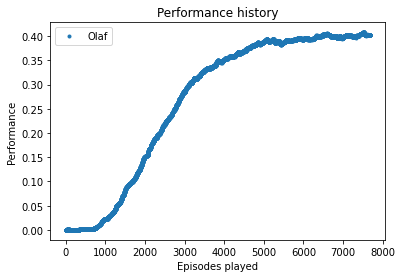

In [50]:
Olaf.play(FrozenLake8x8)
view_performance_history([Olaf])

In [51]:
N=int(round(1.0/np.log(1.0/(1.0-Olaf.decay_weight))))
N

768

In [52]:
sum(Olaf.history[-N:])/N

0.4027705639107606

The asymptotic performance of Olaf is around $P=0.40$. Since the return for a single goal achieved episode is $\gamma^T$, where $T$ is the number of time_steps needed for completion, we can see that, on average, Olaf takes $T=\frac{\log(P)}{\log(\gamma)}\approx 91$ time steps to achieve the goal when playing on its maximum skill level. 

In comparison, if this were a deterministic GridWorld environment, it would take 14 time steps for an optimal agent to finish the task!

In [ ]:
#Olaf.play(FrozenLake8x8, episodes=1, view=True)

In [54]:
joblib.dump(Olaf, 'Olaf')

['Olaf']

## Performance impact of asymptotic learning rates.

In [ ]:
agents_list=[]
for inf_value in np.logspace(-3,0,num=5, endpoint=False):
    agents_list.append(Q_learning_Agent(name='alpha_inf='+str(round(inf_value,3)), alpha_inf=inf_value))


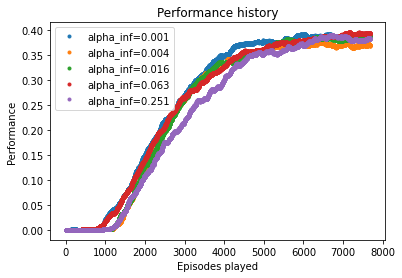

In [ ]:
for agent in agents_list:
    agent.reset_to_env(FrozenLake8x8)
    agent.play(FrozenLake8x8)
view_performance_history(agents_list)

## Performance impact of asymptotic exploraition probabilities.

In [ ]:
agents_list.clear()
for inf_value in np.logspace(-3,0,num=5, endpoint=False):
    agents_list.append(Q_learning_Agent(name='epsilon_inf='+str(round(inf_value,3)), epsilon_inf=inf_value, alpha_inf=0.05))

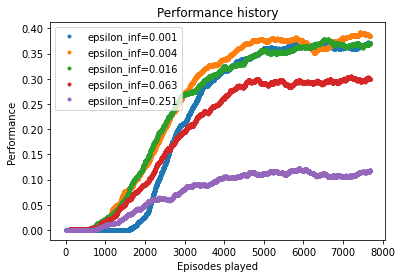

In [ ]:
for agent in agents_list:
    agent.reset_to_env(FrozenLake8x8)
    agent.play(FrozenLake8x8)
view_performance_history(agents_list)

## Conclusions

* We demonstrated that a terminal exploration degrades asymptotic performance, although this effect became significant only for $\epsilon_\infty$ around $5\%$ or better in this study.

* In contrast, the $\alpha_\infty$ parameter did not affect the asymptotic performance, but large values significantly diminish sample efficiency.

* The heuristic $n_d=env.nS*env.nA*\bar{t}$ turned out to work quite well, at least in this task. Of course, it will have limitations for larger environments. Nevertheless, even in those cases, it might be useful as a baseline to think about how long it will take for the agent to master a certain environment.

# Testing the heuristics in other environments

## Taxi-v3

In [55]:
Taxi=gym.make('Taxi-v3')
Taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [56]:
Ranjit=Q_learning_Agent(name='Ranjit', alpha_inf=0.0, epsilon_inf=0.0)
Ranjit.reset_to_env(environment=Taxi)

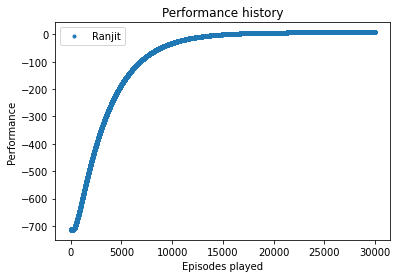

In [57]:
Ranjit.play(Taxi)
view_performance_history([Ranjit])

In [58]:
N=int(round(1.0/np.log(1.0/(1.0-Ranjit.decay_weight))))
N

3000

In [59]:
sum(Ranjit.history[-N:])/N

7.887

At this point, Ranjit takes 12 steps, on average, to complete a run.

In [ ]:
#Ranjit.play(Taxi, episodes=1, view=True)

In [61]:
joblib.dump(Ranjit, 'Ranjit')

['Ranjit']